 ## <font color = "#ef4155"> **Partie 02: Classification des images**

### <font color = "#ef4155"> **Import des bibliothèques**

In [1]:
# Importation des bibliothèques
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import time
import cv2 as cv2
import keras
from keras.preprocessing import image
from keras.models import Model
from PIL import Image, ImageOps, ImageFilter
from matplotlib.image import imread
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.python.keras.layers import Flatten

# Désactivation des avertissements futurs
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Configuration du style de tracé
sns.set_theme(style="white")

# Fonctions et classes pour l'analyse de clusters
from sklearn import metrics
from sklearn import cluster
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import manifold, decomposition
from yellowbrick.cluster import SilhouetteVisualizer

# Chargement de modèles de pré-entraînement
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.python.keras.layers import Flatten

### <font color = "#ef4155"> **Chargement des données**

In [2]:
# Chargement du jeu de données
data = pd.read_csv('data.csv')

# Visualisation des deux premières lignes
data.head(2)

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   

                                        product_name               pid  \
0  Elegance Polyester Multicolor Abstract Eyelet ...  CRNEG7BKMFFYHQ8Z   
1                         Sathiyas Cotton Bath Towel  BTWEGFZHGBXPHZUH   

   retail_price  discounted_price                                 image  \
0        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   

   is_FK_Advantage_product                                        description  \
0                    False  Key Features of Elegance Polyester Multicolor ...   
1                    False  Specifications of Sathiyas Cotton Bath Towel (...   

        product_rating       overall_rating     brand  \
0  No rating available  No rating available  Elegance   
1  No rating available  No rating available  Sathiyas   

                              product_specifications        categorie  
0  {"product_specification"=>[{"key"=>"Brand", "v...  Home Furnishing  
1  {"product_specification"=>[{"key"=>"Machine Wa...        Baby Care

Les images sont stockés dans un dossier différent du dossier. Je vais créer une colonne qui contient le chemin complet vers chaque image, ce qui permettra de charger les images.

In [3]:
# Chemin du répertoire contenant les images
path = "./Images/"

# Création une nouvelle colonne 'image_loc' dans le DataFrame. Cette colonne contiendra les chemins complets vers les images en utilisant os.path.join()
data['image_loc'] = [os.path.join(path, row) for row in data['image']]

In [4]:
# Création d'une copie du jeu de données pour ne pas modifier le jeu de données original
data_image = data.copy()

# Sélection des colonnes à utiliser
data_image= data_image[['image', 'image_loc', 'categorie']]

# Visualisation aléatoire de 3 lignes
data_image.sample(3)

image  \
181  59af3731b809a25f2bf99e99f645d8dd.jpg   
443  2231a6fc63274c46043e353f1728f077.jpg   
948  c417f408340252f170f05dadf88160d7.jpg   

                                         image_loc                   categorie  
181  ./Images/59af3731b809a25f2bf99e99f645d8dd.jpg            Kitchen & Dining  
443  ./Images/2231a6fc63274c46043e353f1728f077.jpg             Home Furnishing  
948  ./Images/c417f408340252f170f05dadf88160d7.jpg  Home Decor & Festive Needs

_Dans le notebook précédent, chaque catégorie avait 150 images. Je vais vérifier que c'est toujours le cas_

In [5]:
# Comptage du nombre d'images par catégorie
image_categorie = data_image.groupby('categorie').agg({'image' : 'count'})

# Affichage
image_categorie

image
categorie                        
Baby Care                     150
Beauty and Personal Care      150
Computers                     150
Home Decor & Festive Needs    150
Home Furnishing               150
Kitchen & Dining              150
Watches                       150

**Aperçu de quelques images par catégories**

Home Furnishing


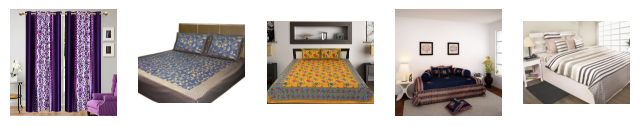

Baby Care


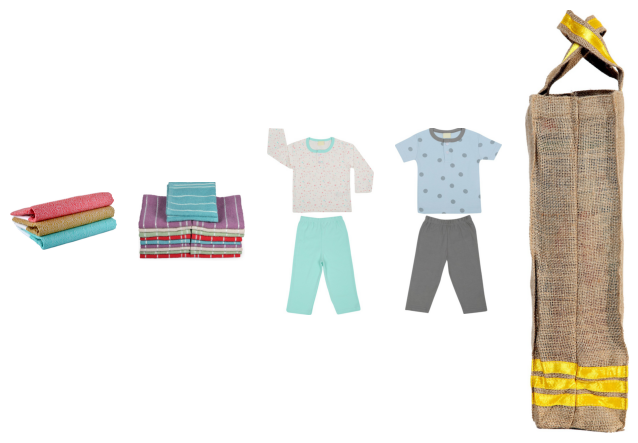

Watches


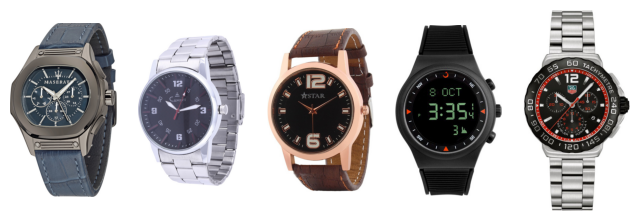

Home Decor & Festive Needs


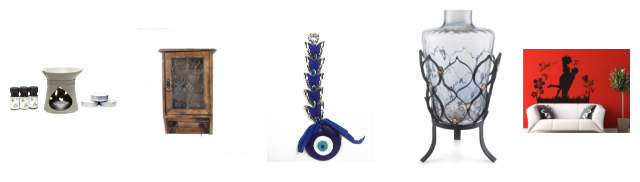

Kitchen & Dining


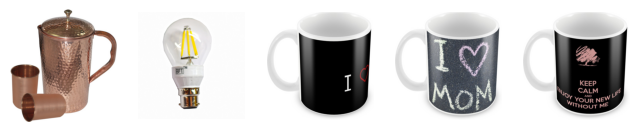

Beauty and Personal Care


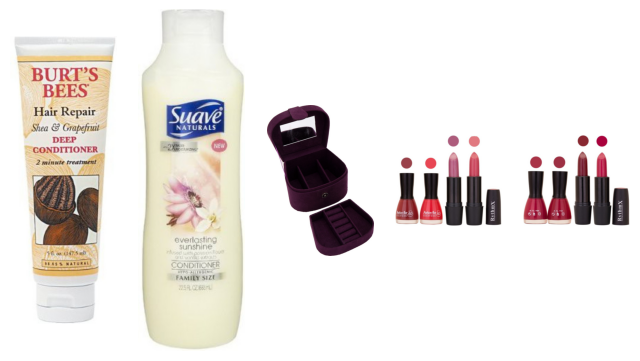

Computers


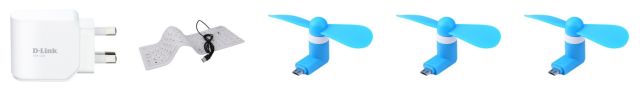

In [6]:
# Parcourir les catégories du DataFrame 
for j, categ in enumerate(data_image["categorie"].unique()) :

    # Afficher les noms des catégories en gras
    bolded_string = "\033[1m" + categ + "\033[0m"
    print(bolded_string)
    
    # Parcourir les cinq premières images de la catégorie actuelle
    for i in range(5):
        # Extraire le nom de l'image à partir du DataFrame pour la catégorie actuelle
        name_image = data_image[data_image["categorie"] == categ]["image"].iloc[i]
        
        # Configurer l'affichage en grille avec trois sous-plots
        plt.subplot(150 + 1 + i)
        
        # Construire le chemin complet vers l'image en utilisant os.path.join()
        filename = path + name_image
        
        # Charger l'image à partir du fichier
        img = imread(filename)
        
        # Afficher l'image dans le sous-plot et désactiver les axes
        plt.imshow(img)
        plt.axis('off')
    
    # Afficher les trois images de la catégorie actuelle
    plt.show()


_Les images semble correspondre à leurs catégories respectives_

**Extraction des caractéristiques des images :** taille, format, largeur et hauteur

In [7]:
# Fonction pour extraire les informations d'une image
def extract_image_info(image_path):
    img = Image.open(image_path)
    width, height = img.size
    size = width * height
    format = img.mode
    return width, height, size, format

# Application de la fonction aux données et ajout des colonnes correspondantes
image_info = data_image['image_loc'].apply(extract_image_info)
data_image[['Largeur_image', 'Hauteur_image', 'Taille_image', 'Format_image']] = pd.DataFrame(image_info.tolist(), index=data_image.index)

# Affichage d'un échantillon de 3 lignes du DataFrame
data_image.sample(3)


c:\Users\alain\anaconda3\lib\site-packages\PIL\Image.py:3167: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


image  \
28   b52073e7ed9c00c4108cae4eb0c49c1a.jpg   
343  9743e6d1c9f3180483825fe4d2e97836.jpg   
447  8e961e4fd248c9496ca54808d2d2b25f.jpg   

                                         image_loc  categorie  Largeur_image  \
28   ./Images/b52073e7ed9c00c4108cae4eb0c49c1a.jpg    Watches            711   
343  ./Images/9743e6d1c9f3180483825fe4d2e97836.jpg  Computers            534   
447  ./Images/8e961e4fd248c9496ca54808d2d2b25f.jpg  Computers           1413   

     Hauteur_image  Taille_image Format_image  
28            1304        927144          RGB  
343            541        288894          RGB  
447           1258       1777554          RGB

### <font color = "#ef4155"> **Pré-traitement des images**

#### <font color = "blue"> **Illustration du pré-traitement sur une image**

In [8]:
def plot_image_histogram(image, title):
    fig, axes = plt.subplots(1, 3, figsize=(40, 10))

    # Affichage de l'image
    axes[0].imshow(image, cmap='gray')
    axes[0].set_title(title, fontsize=26, color = "#ef4155", fontweight = "bold")
    axes[0].tick_params(axis='both', which='both', labelsize=20)
    axes[0].axis('off')

    # Histogramme de répartition des pixels
    hist, bins = np.histogram(np.array(image).flatten(), bins=256)
    axes[1].bar(range(len(hist[0:255])), hist[0:255])
    axes[1].set_title('Histogramme de répartition des pixels', fontsize=26, color = "#ef4155", fontweight = "bold")
    axes[1].set_xlabel('Niveau de gris', fontsize=20)
    axes[1].set_ylabel('Nombre de pixels', fontsize=20)
    axes[1].tick_params(axis='both', which='both', labelsize=20)

    # Histogramme cumulé des pixels
    axes[2].hist(np.array(image).flatten(), bins=range(256), cumulative=True)
    axes[2].set_title('Histogramme cumulé des pixels', fontsize=26, color = "#ef4155", fontweight = "bold")
    axes[2].set_xlabel('Niveau de gris', fontsize=24)
    axes[2].set_ylabel('Fréquence cumulée de pixels', fontsize=20)
    axes[2].tick_params(axis='both', which='both', labelsize=20)

    plt.show()

_Définition des dimmensions pour redimensionner les images de manière à ce que la lageur et la hauteur soient toutes deux égales à 225 pixels_

In [9]:
dim = (225, 225)

##### <font color = "green"> Image témoin 

_Sélection de manière aléatoire d'une image pour le prétraitement_

In [10]:
data_image.sample(1, random_state=0)

image  \
743  d47f1cb78db4a23e2516e2d34da34c8a.jpg   

                                         image_loc         categorie  \
743  ./Images/d47f1cb78db4a23e2516e2d34da34c8a.jpg  Kitchen & Dining   

     Largeur_image  Hauteur_image  Taille_image Format_image  
743            223            500        111500          RGB

_Appel de la fonction plot_image_histogram_

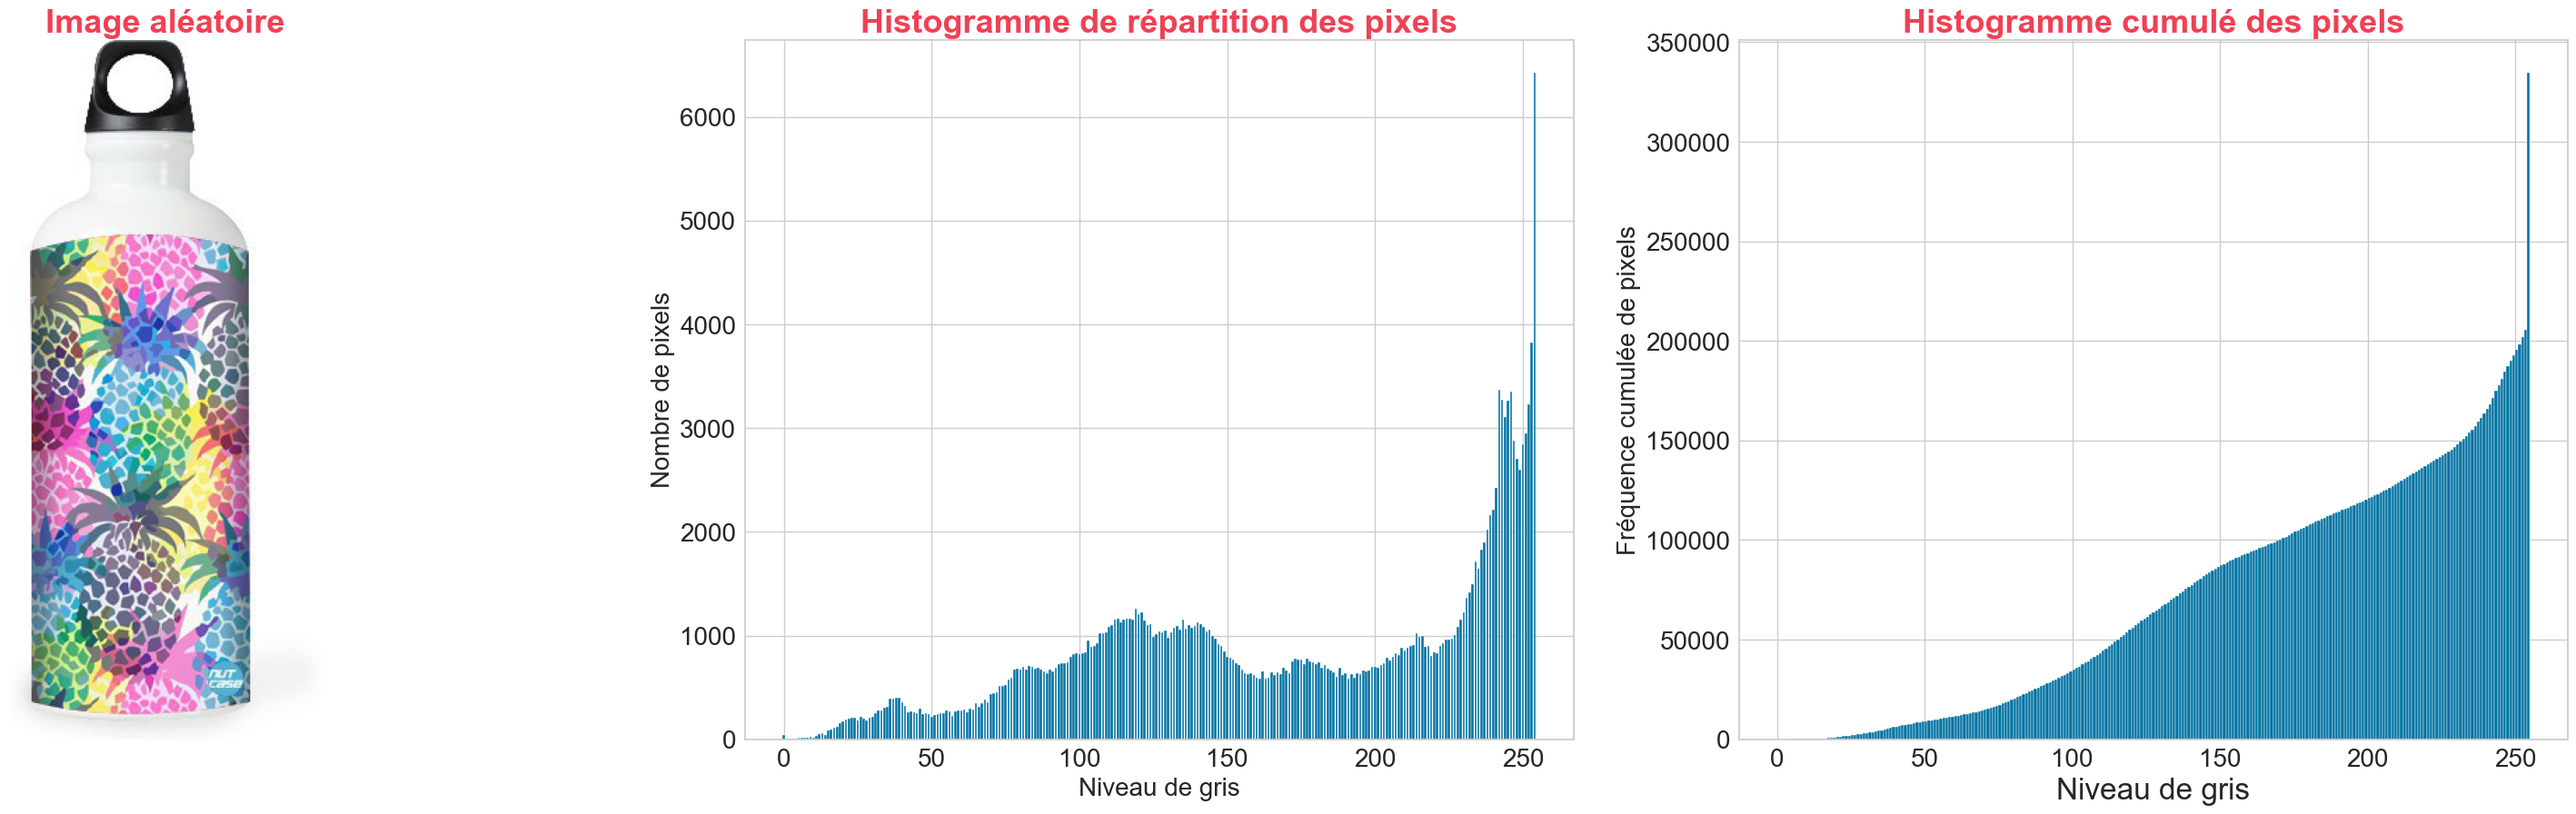

In [11]:
image_test = Image.open("./Images/d47f1cb78db4a23e2516e2d34da34c8a.jpg")
plot_image_histogram(image_test, "Image aléatoire")

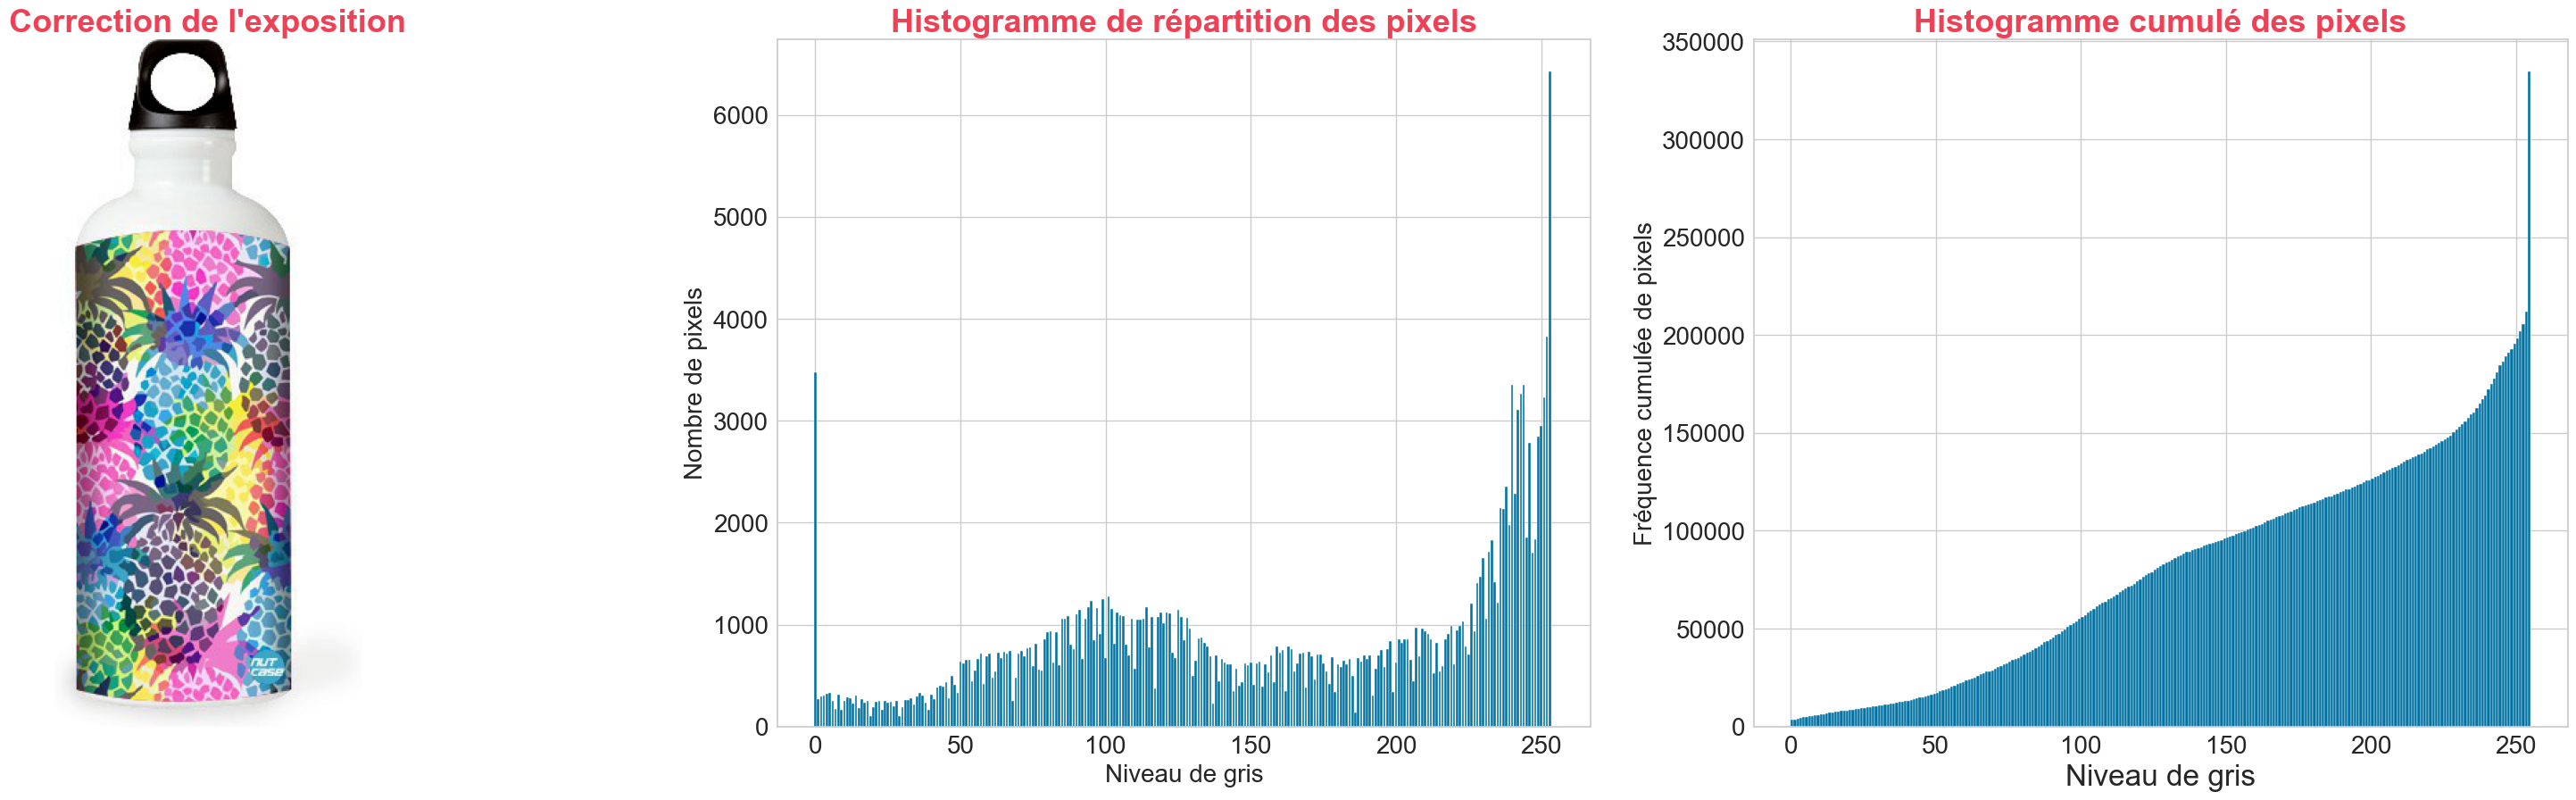

In [12]:
# Correction de l'exposition PILS
exposition = ImageOps.autocontrast(image_test, 1)
plot_image_histogram(exposition, "Correction de l'exposition")

**Correction du contraste (égalisation d'histogramme)**

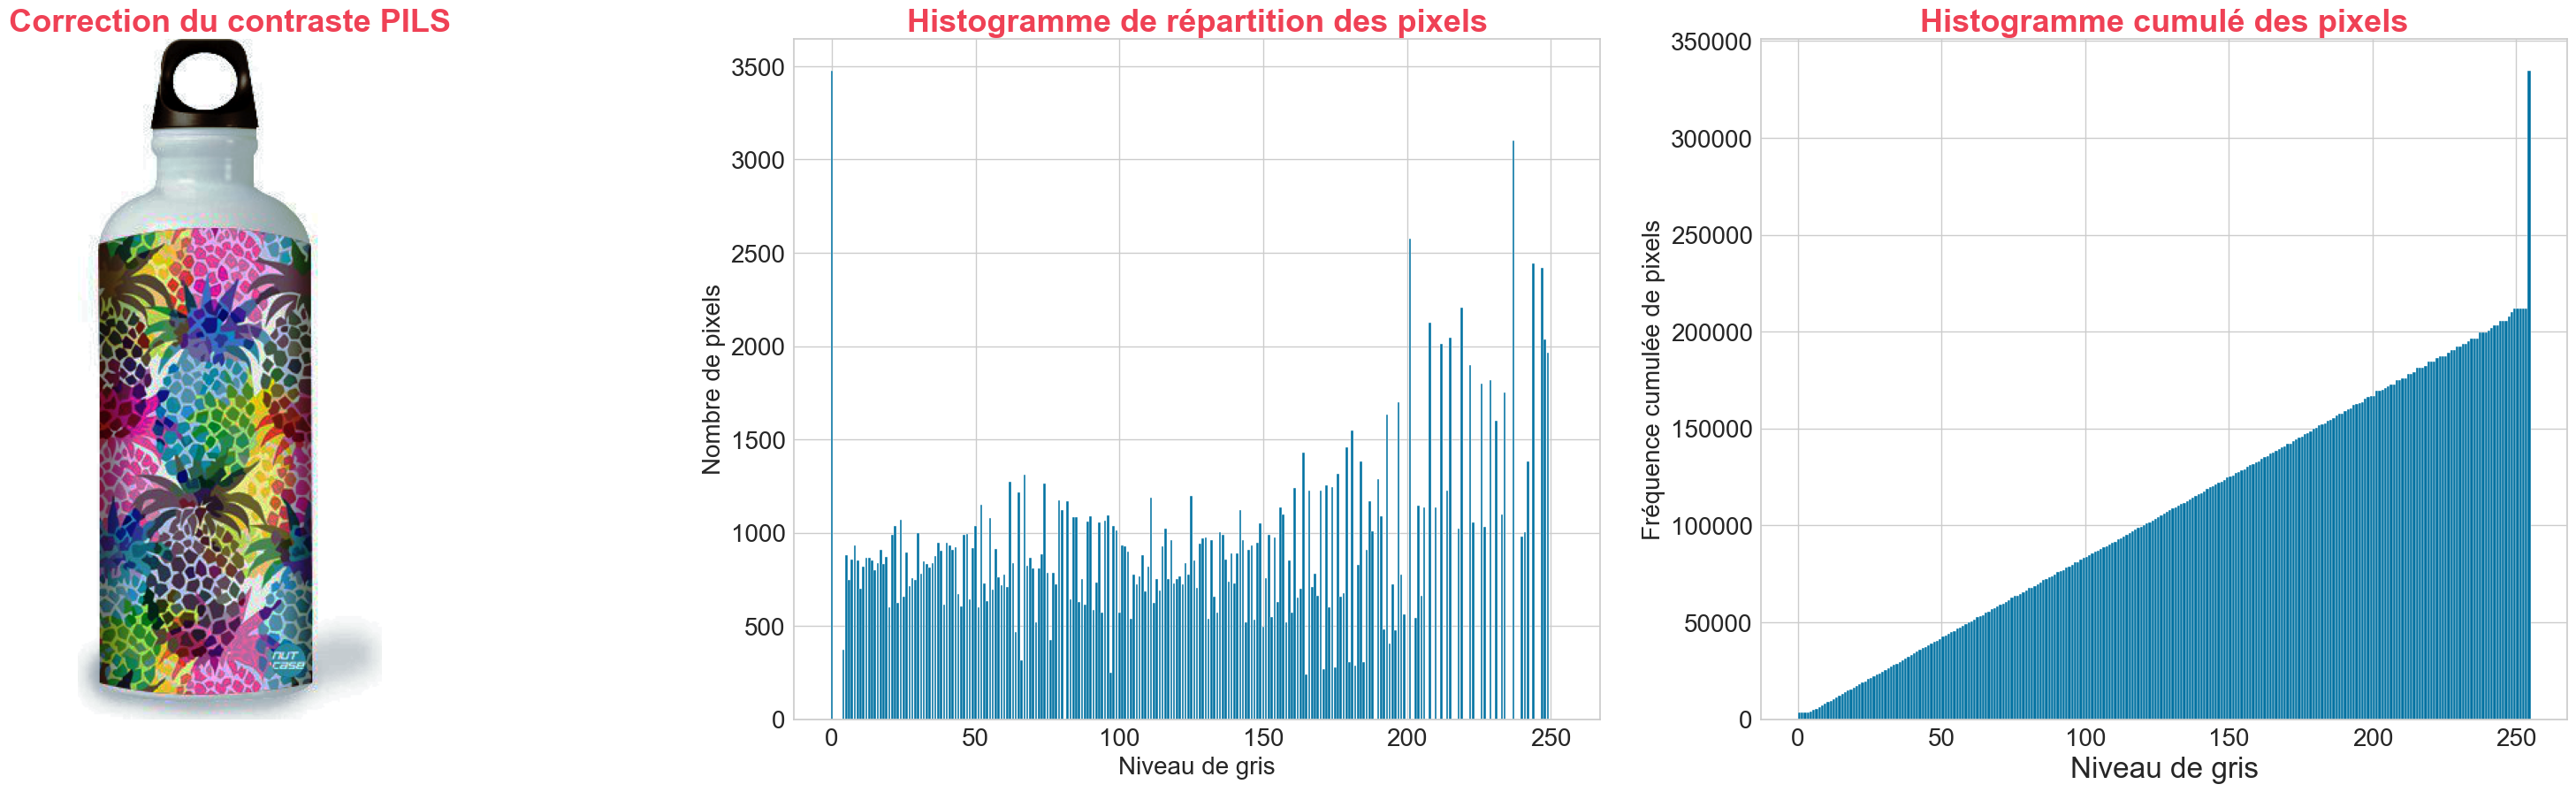

In [13]:
# Correction du contraste PILS
contraste = ImageOps.equalize(exposition)
plot_image_histogram(contraste,'Correction du contraste PILS')

**Réduction du bruit (lissage)**

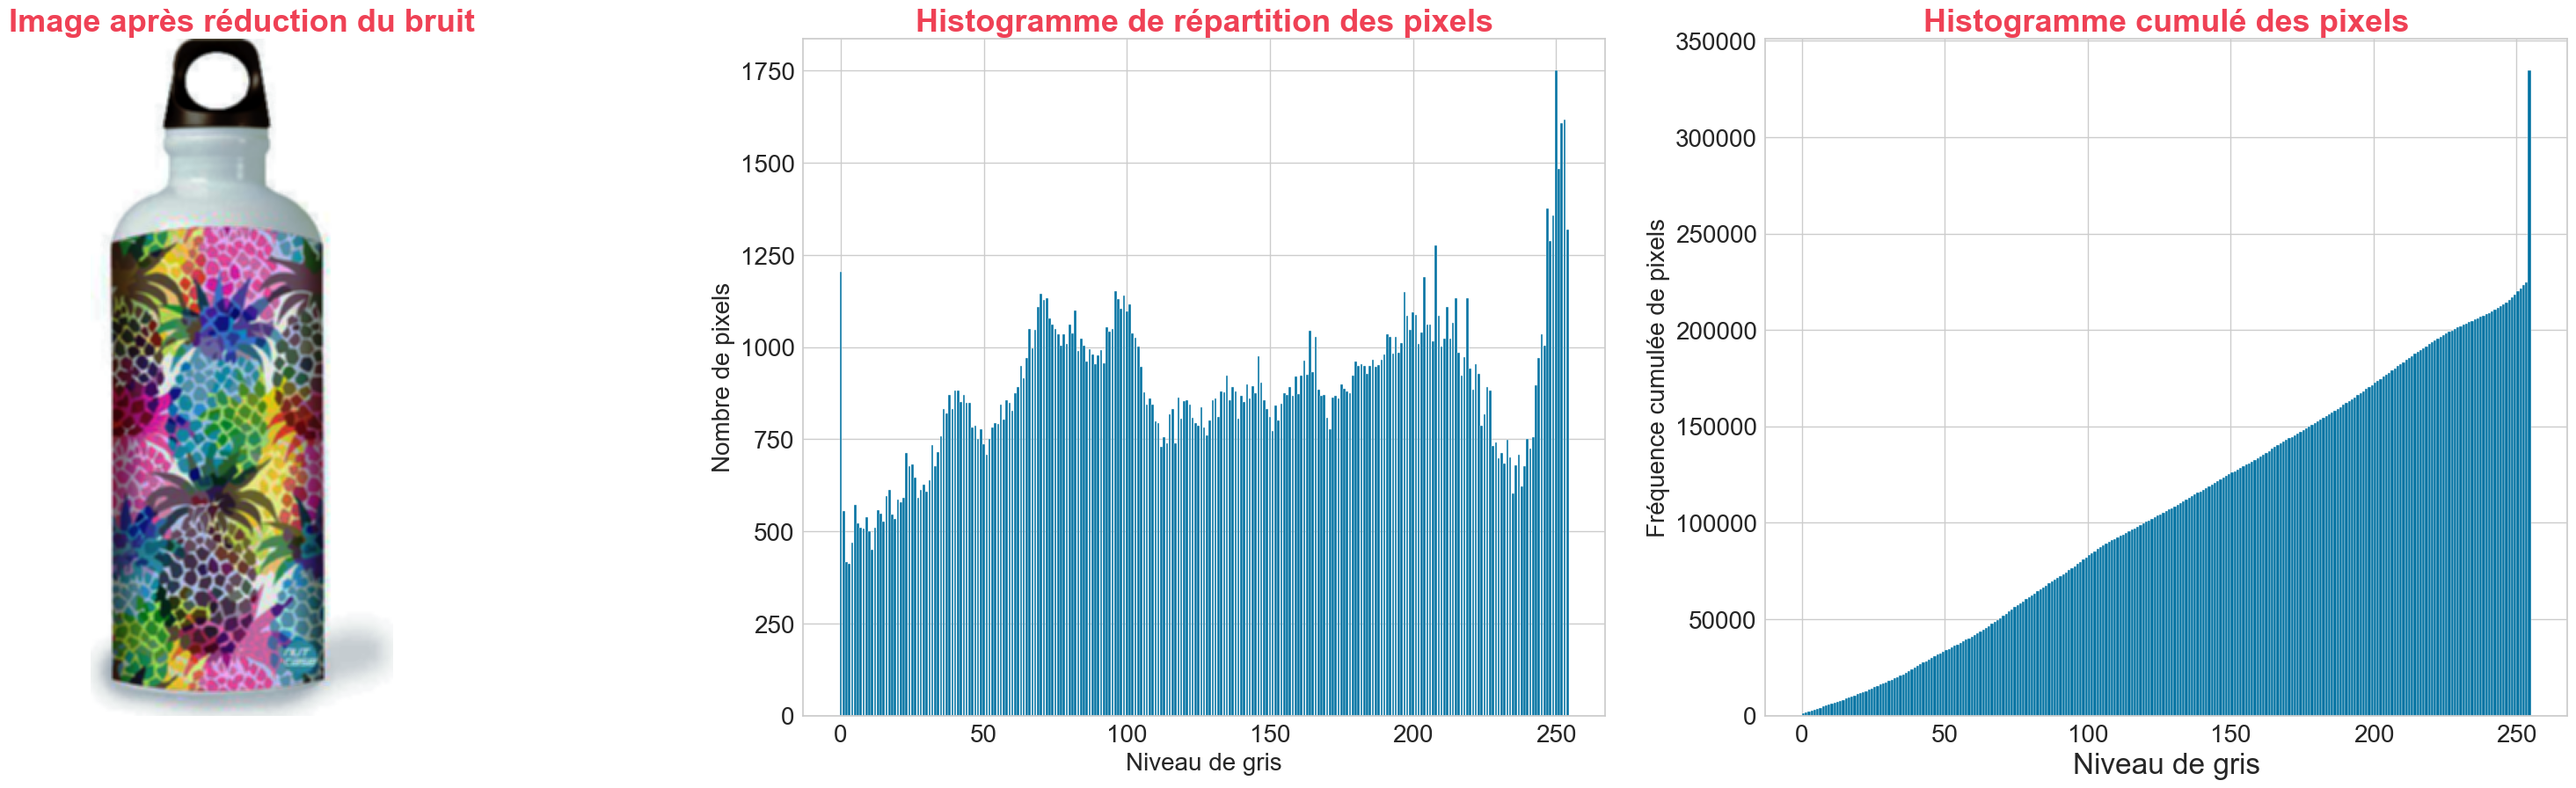

In [14]:
# Réduction du bruit (filtre)
image_filtrer = contraste.filter(ImageFilter.BoxBlur(1))
plot_image_histogram(image_filtrer,'Image après réduction du bruit')

**Convertir l'image en niveau de gris**

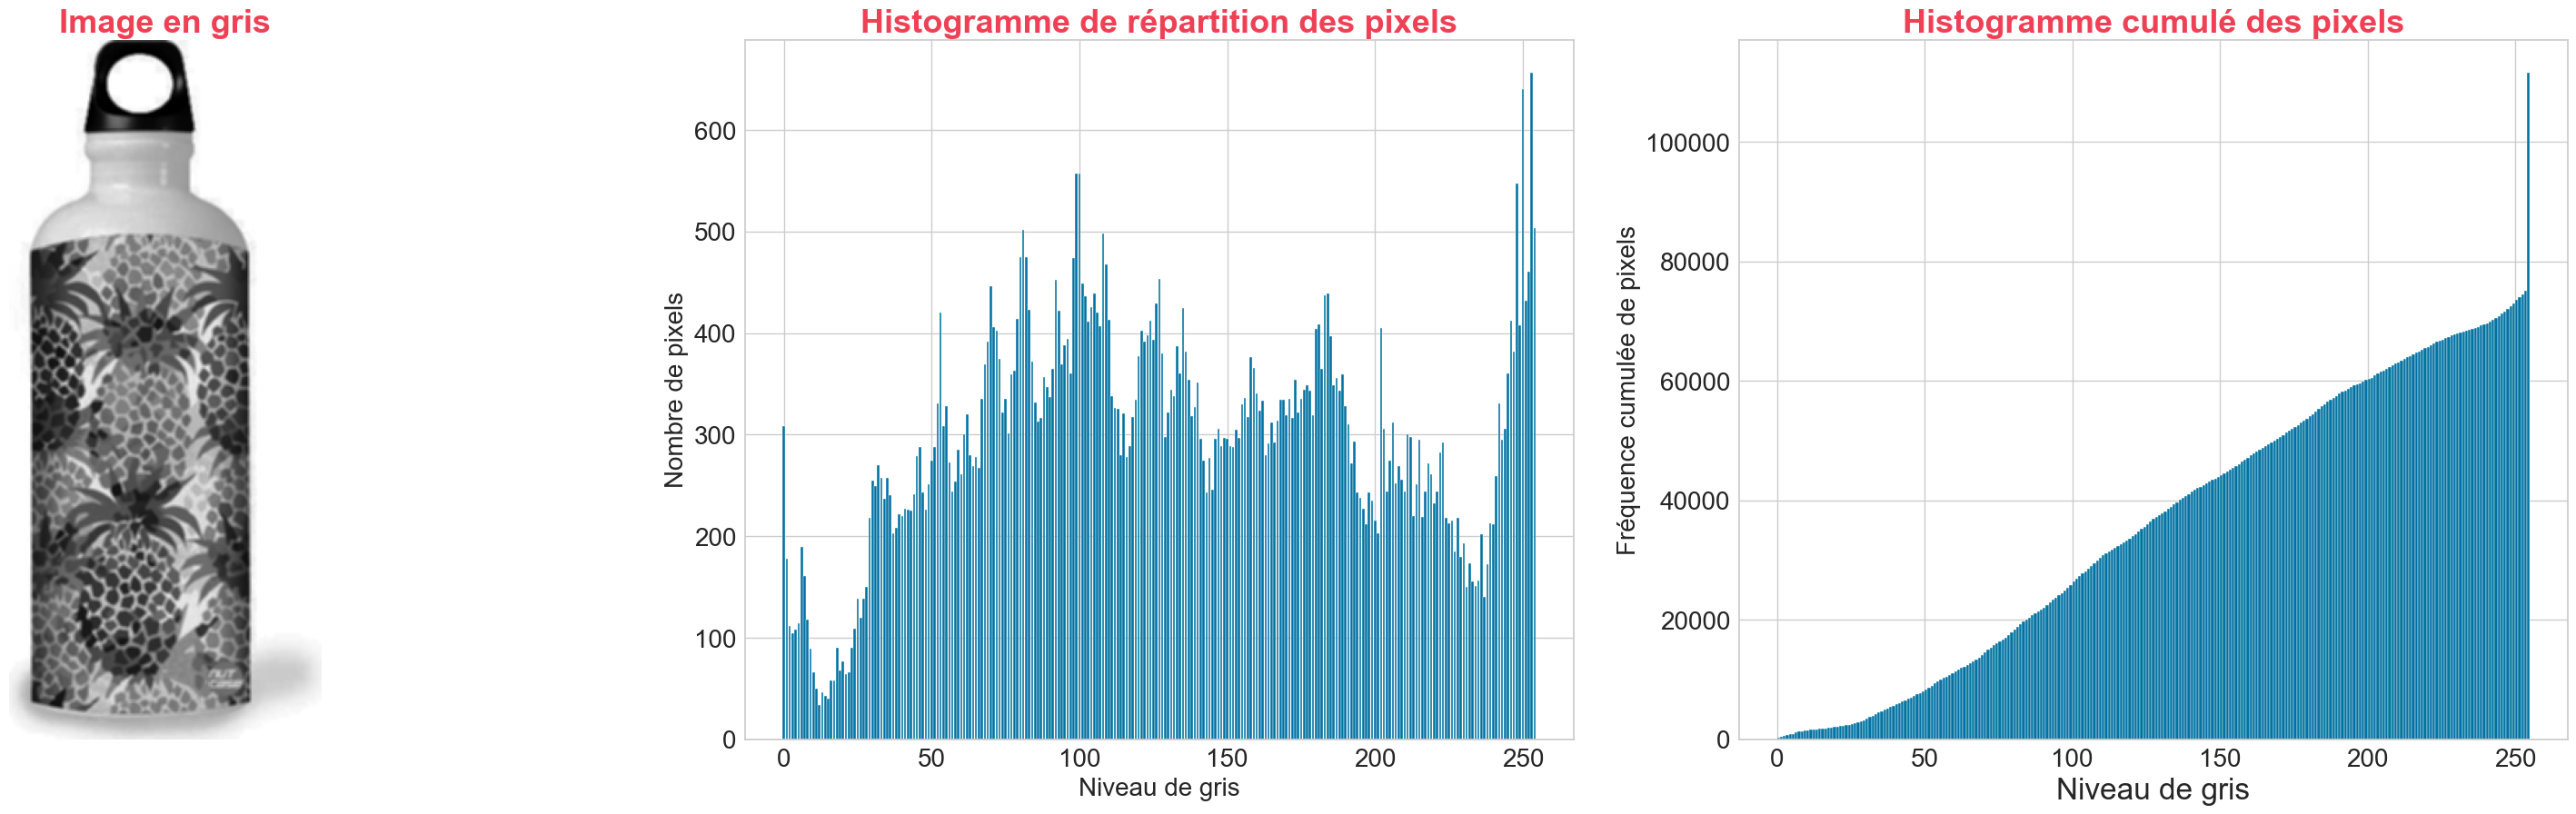

In [15]:
# Conversion de l'image en niveau de gris pour SIFT
image_gris = cv2.cvtColor(np.array(image_filtrer), cv2.COLOR_RGB2GRAY)
plot_image_histogram(image_gris,'Image en gris')

#### <font color = "blue"> **Pré-traitement de toutes les images**

In [16]:
def preprocess_images(image):

    # Nom de l'image
    file_dir = os.path.split(image)

    # Chargement de l'image originale
    img = Image.open(image)

    # Correction de l'exposition PILS (étirement de l'histogramme)
    img = ImageOps.autocontrast(img, 1)

    # Correction du contraste (égalisation de l'histogramme)
    img = ImageOps.equalize(img)
    
    # Réduction du bruit 
    img = img.filter(ImageFilter.BoxBlur(1))
    
    # Conversion en niveau de gris de l'image
    img = cv2.cvtColor(np.array(img), cv2.COLOR_BGR2GRAY)    
         
    # Redimensionnement en 225 * 225
    img = cv2.resize(np.array(img), dim, interpolation=cv2.INTER_AREA)

    # Sauvegarde de l'image dans le répertoire data/Images_process
    cv2.imwrite('./Images/Image_process/' + file_dir[1], img)

    return './Images/Image_process/' + file_dir[1]

In [17]:
# Pré-traitement de toutes les images
data_image['images_processed'] = data_image['image_loc'].apply(preprocess_images)
data_image.head(3)

c:\Users\alain\anaconda3\lib\site-packages\PIL\Image.py:3167: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


image  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2  64d5d4a258243731dc7bbb1eef49ad74.jpg   

                                       image_loc        categorie  \
0  ./Images/55b85ea15a1536d46b7190ad6fff8ce7.jpg  Home Furnishing   
1  ./Images/7b72c92c2f6c40268628ec5f14c6d590.jpg        Baby Care   
2  ./Images/64d5d4a258243731dc7bbb1eef49ad74.jpg        Baby Care   

   Largeur_image  Hauteur_image  Taille_image Format_image  \
0           3600           3600      12960000          RGB   
1           2388           1293       3087684          RGB   
2            982            729        715878          RGB   

                                    images_processed  
0  ./Images/Image_process/55b85ea15a1536d46b7190a...  
1  ./Images/Image_process/7b72c92c2f6c40268628ec5...  
2  ./Images/Image_process/64d5d4a258243731dc7bbb1...

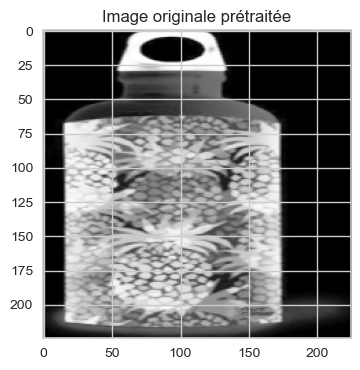

In [18]:
# Chargement de l'image préalablement traitée
img_path = './Images/Image_process/d47f1cb78db4a23e2516e2d34da34c8a.jpg'
img = imread(img_path)

# Visualisation de l'image
plt.figure(figsize=(30, 4))
plt.title('Image originale prétraitée')
plt.imshow(img)
plt.show()


##### <span style='background:#ef4155'> <font color = "white"> **Approche SIFT (Scale Invariant Feature Transform)**

**Protocole :**

1- Extraction des descripteurs ;
         
2- Clustering :

3- Et analyse visuelle.

_**Extraction des descripteurs sur une image**_

In [19]:
def gen_sift_features(gray_img):
    # Créer un objet SIFT
    sift = cv2.SIFT_create()
    
    # Détecter et calculer les keypoints et descripteurs SIFT de l'image en niveaux de gris
    kp, desc = sift.detectAndCompute(gray_img, None)
    
    # Retourner les keypoints et descripteurs SIFT
    return kp, desc

In [20]:
# Transformation de l'image en une matrice de pixels pour OpenCV
mug = np.array(img)

# Extraction des keypoints et descripteurs SIFT en utilisant la fonction générique
sift_keypoints, sift_descriptors = gen_sift_features(img)

# Affichage des informations sur les descripteurs
print(f"L'image contient {sift_descriptors.shape[0]} descripteurs SIFT")
print(f'Chaque descripteur est un vecteur de longueur {sift_descriptors.shape[1]}')

L'image contient 695 descripteurs SIFT
Chaque descripteur est un vecteur de longueur 128


C:\Users\alain\AppData\Local\Temp\ipykernel_1488\1758961180.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


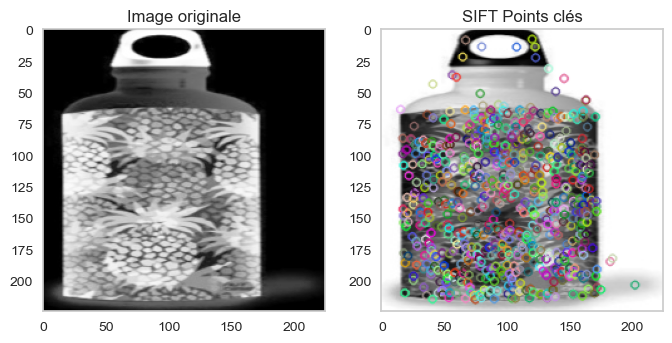

In [21]:
# Visualisation des points d'intérêt
sift_img_keypoints = cv2.drawKeypoints(img, sift_keypoints, None)

plt.figure(figsize=(8, 4))
plt.grid(False)

# Image originale
plt.subplot(1, 2, 1)
plt.grid(False)
plt.title('Image originale')
plt.imshow(img)

# Image avec les points clés
plt.subplot(1, 2, 2)
plt.grid(False)
plt.imshow(sift_img_keypoints)
plt.title('SIFT Points clés')

plt.show()

_**Extraction des descripteurs SIFT sur l'ensemble des images**_

In [22]:
def load_image_in_dict(repertoire):
    # Chargement des images pré-traitées dans un dictionnaire d'images
    images = {}
    for filename in os.listdir(repertoire):
        path = repertoire + "/" + filename
        img = cv2.imread(path, 0)
        images[filename] = img
    return images

In [23]:
# Chargement des images pré-traitées dans le dictionnaire images
images = load_image_in_dict('./Images/Image_process/')
print(f'{len(images)} images chargées')

1050 images chargées


_**Clustering des descripteurs**_

In [24]:
# Création des labels à partir du nom de catégorie produit
le = preprocessing.LabelEncoder()
data_image["label"] = le.fit_transform(data_image["categorie"])
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{'Baby Care': 0, 'Beauty and Personal Care': 1, 'Computers': 2, 'Home Decor & Festive Needs': 3, 'Home Furnishing': 4, 'Kitchen & Dining': 5, 'Watches': 6}


_**Construction de l'histogramme pour chaque image (Bag of Visual Words)**_

In [25]:
list_photos=data_image['images_processed']

In [26]:
import cv2
import numpy as np
import time

# identification of key points and associated descriptors

sift_keypoints = []
temps1=time.time()
sift = cv2.SIFT_create(500)

for image_num in range(len(list_photos)) :
    if image_num%100 == 0 : print(image_num)
    image = cv2.imread(list_photos[image_num],0) # convert in gray
    res = cv2.equalizeHist(image)   # equalize image histogram
    kp, des = sift.detectAndCompute(res, None)
    sift_keypoints.append(des)

sift_keypoints_by_img = np.asarray(sift_keypoints)
sift_keypoints_all    = np.concatenate(sift_keypoints_by_img, axis=0)

print()
print("Nombre de descripteurs : ", sift_keypoints_all.shape)

duration1=time.time()-temps1
print("temps de traitement SIFT descriptor : ", "%15.2f" % duration1, "secondes")

0


100
200
300
400
500
600
700
800
900
1000

Nombre de descripteurs :  (341569, 128)
temps de traitement SIFT descriptor :            53.11 secondes


C:\Users\alain\AppData\Local\Temp\ipykernel_1488\27715088.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sift_keypoints_by_img = np.asarray(sift_keypoints)


### **Création des clusters de descripteurs**


Utilisation de MiniBatchKMeans pour obtenir des temps de traitement raisonnables

In [27]:
k = int(round(np.sqrt(len(sift_keypoints_all)),0))
print("Nombre de clusters estimés : ", k)
print("Création de",k, "clusters de descripteurs ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(sift_keypoints_all)

Nombre de clusters estimés :  584
Création de 584 clusters de descripteurs ...


MiniBatchKMeans(init_size=1752, n_clusters=584, random_state=0)

_**Création des features des images**_

In [28]:
# Création d'histogrammes (features)
temps1=time.time()

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Création de matrice d'histogrammes
hist_vectors=[]

for i, image_desc in enumerate(sift_keypoints_by_img) :
    if i%100 == 0 : print(i)  
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

im_features = np.asarray(hist_vectors)

duration1=time.time()-temps1
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")

0
100
200
300
400
500
600
700
800
900
1000
temps de création histogrammes :            65.31 secondes


_**Réduction de dimension**_

_**ACP**_

In [29]:
print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.99)
pca_results_img= pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", pca_results_img.shape)

Dimensions dataset avant réduction PCA :  (1050, 584)
Dimensions dataset après réduction PCA :  (1050, 480)


_**Tsne**_

In [30]:
tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
tsne_results_img = tsne.fit_transform(pca_results_img)

df_tsne_img = pd.DataFrame(tsne_results_img[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne_img["class"] = data_image["categorie"]
print(df_tsne_img.shape)

(1050, 3)


_**Visualisation**_

In [31]:
# Création d'un dataframe X contenant les colonnes tsne1 et tsne2
X = df_tsne_img[["tsne1", "tsne2"]]

# Création d'un modèle KMeans avec 7 clusters, un init de k-means++, et un random_state de 0
cls = KMeans(n_clusters=7, init='k-means++', random_state=0)

# Adaptation du modèle KMeans au dataframe X
cls.fit(X)

# Ajout d'une colonne cluster au dataframe df_tsne_img contenant les étiquettes des clusters
df_tsne_img["cluster"] = cls.labels_

# Calcul du score de silhouette
sil = silhouette_score(X, cls.labels_, metric="euclidean")

# Imprimer le score de silhouette
print("Le score de silhouette est", sil)

Le score de silhouette est 0.35475346


In [32]:
# Création des labels à partir du nom de catégory produit
data_image["label"] = le.fit_transform(data_image["categorie"])

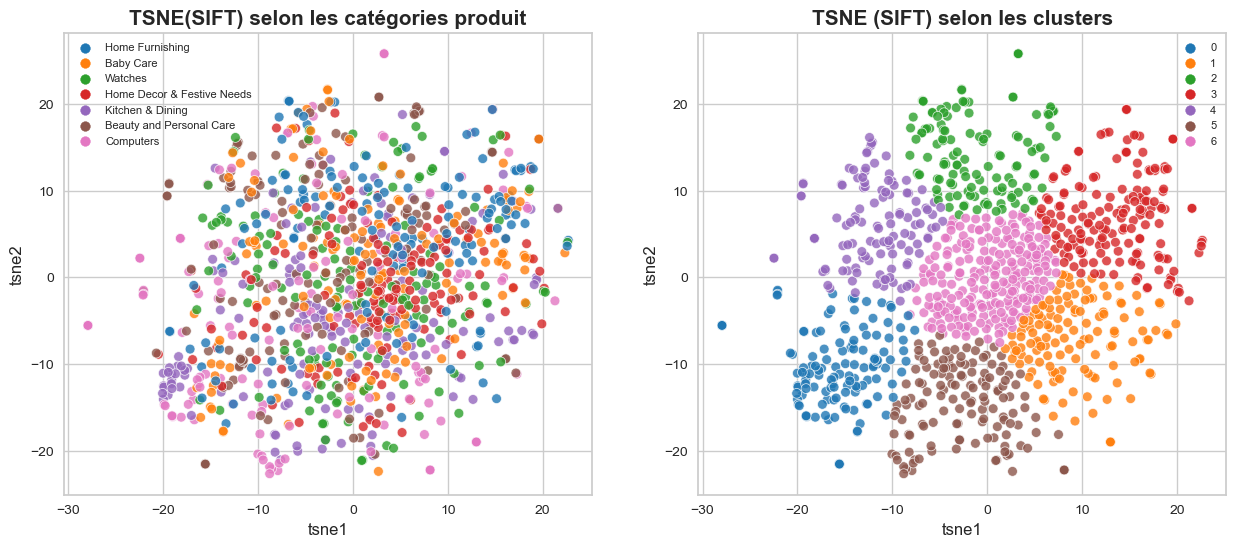

---------------------------
ARI :  0.022782700228246702
---------------------------


In [33]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(121)
    

sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne_img, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.8)

plt.title('TSNE(SIFT) selon les catégories produit', fontsize = 15, fontweight = 'bold')
plt.xlabel('tsne1')
plt.ylabel('tsne2')
plt.legend(prop={'size': 8}) 



ax = fig.add_subplot(122)
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.8,
    data=df_tsne_img,
    legend="brief")

plt.title('TSNE (SIFT) selon les clusters', fontsize =15, fontweight = 'bold')
plt.xlabel('tsne1')
plt.ylabel('tsne2')
plt.legend(prop={'size': 8}) 

plt.show()


print("---------------------------")
labels = data_image["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))
print("---------------------------")


**Répartition des vraies catégories par cluster**

Je vais utiliser la matrice de confusion pour visualiser la répartition des images par clusters et par catégorie.

In [34]:
# Affiche la matrice de confusion

def confusion_matrix(y_true, y_pred, title):
    # Créer un DataFrame contenant les labels réels et les labels prédits
    data = pd.DataFrame({'Labels': y_true, 'Clusters': y_pred})
    
    # Calculer la matrice de confusion
    ct = pd.crosstab(data['Labels'], data['Clusters'])
    
    # Créer une figure et un axe
    fig, ax = plt.subplots(figsize=(6, 4))
    
    # Afficher la matrice de confusion en tant que heatmap
    sns.heatmap(ct.T, square=True, annot=True, annot_kws={"size": 10}, fmt='.0f', cmap=sns.cubehelix_palette(as_cmap=True), cbar=False, ax=ax)
    
    # Configurer les labels des axes
    ax.set_title(title, fontsize=12, color = "#ef4155", fontweight = "bold")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=12)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha="right", fontsize=12)
    ax.set_ylabel("Clusters", fontsize=15)
    ax.set_xlabel("Labels", fontsize=15)
    
    # Afficher la figure
    plt.show()

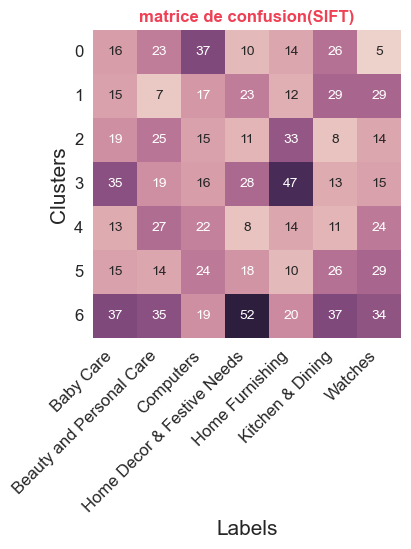

In [35]:
confusion_matrix(df_tsne_img["class"], df_tsne_img["cluster"], 'matrice de confusion(SIFT)')

#### <span style='background:#ef4155'> <font color = "white"> Méthode Transfert Learning avec VGG16

Je vais dans cette section utiliser Keras avec une version pré-entraînée de VGG16.

- VGG-16 est une version du réseau de neurones convolutif VGG-Net.
- VGG-16 est constitué de plusieurs couches, dont 13 couches de convolution et 3 fully-connected. Il doit donc apprendre les poids de 16 couches.
- Il prend en entrée une image en couleurs de taille 224 × 224 px et la classifie dans une des 1000 classes. Il renvoie donc un vecteur de taille 1000, qui contient les probabilités d'appartenance à chacune des classes.

- le Transfer Learning consiste à utiliser le modèle VGG16 pré-entraîné sur ImageNet (ImageNet est un projet de recherche visant à développer une grande base de données d'images avec des annotations, c'est-à-dire des images et leurs descriptions).

**Création du modèle d'étude avec VGG16**

Chargement des images et extraction des features

In [36]:
# Utilisation de VGG16 pré-entraîné sur ImageNet avec les images d'origine

# Liste
vgg16_all_features = []

# Instanciation du modèle
model_vgg16 = VGG16()

# Suppression de la couche de sortie
model_vgg16= Model(inputs=model_vgg16.inputs, outputs=model_vgg16.layers[-2].output)

# Résumé de l'architecture du modèle
model_vgg16.summary()

for rep_image in data_image['image_loc']:

    # Charger l'image et la redimensionner à la taille requise de 224×224 pixels.
    
    img = load_img(rep_image, target_size=(224, 224))
    
    # Convertir les pixels en un tableau NumPy afin de pouvoir travailler avec dans Keras
    img = img_to_array(img)
    
    # Redimensionnement
    img = np.expand_dims(img, axis=0)
    
    # Préparer de nouvelles entrées pour le réseau.
    img = preprocess_input(img)

    # obtenir une prédiction de la probabilité d'appartenance de l'image à chacun des 1000 types d'objets connus.
    
    vgg16_feature = model_vgg16.predict(img)
    
    # Ajouter la feature prédite en nparray à la liste
    vgg16_all_features.append(np.array(vgg16_feature).flatten())

vgg16_all_features = np.array(vgg16_all_features)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

c:\Users\alain\anaconda3\lib\site-packages\PIL\Image.py:3167: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


1/1 [==============================] - 0s 314ms/step


In [37]:
# Dataframe de sauvegarde des BOVW VGG16
# Association des features à chaque image
data_image['vgg16_bovw'] = [vgg16_all_features[i] for i in range(data_image.shape[0])]
# Dataframe de travail
df_vgg16_bovw = data_image[['image', 'image_loc', 'categorie', 'vgg16_bovw']]
# Constituer le dataframe de vecteurs de BOVW VGG16
df_vgg16_vectors = pd.DataFrame.from_records(vgg16_all_features)

In [38]:
df_vgg16_vectors

0         1         2         3         4         5         6     \
0     3.398616  0.859572  0.000000  1.106561  2.266122  2.927240  2.446447   
1     0.000000  0.000000  0.000000  1.172010  0.000000  0.000000  0.000000   
2     0.000000  0.000000  0.000000  4.457807  0.000000  0.000000  0.000000   
3     0.000000  0.070990  0.000000  2.046281  0.000000  0.000000  0.000000   
4     3.417153  0.000000  0.000000  0.000000  1.012359  0.000000  0.000000   
...        ...       ...       ...       ...       ...       ...       ...   
1045  2.312268  2.432937  0.000000  1.860515  3.101231  2.369040  0.000000   
1046  1.217184  0.365275  0.330849  0.000000  2.140627  0.000000  0.000000   
1047  2.196130  2.398275  2.623641  0.983883  0.366650  0.535506  3.730997   
1048  0.000000  0.000000  0.000000  0.000000  0.000000  0.388866  0.000000   
1049  0.000000  0.000000  0.123131  0.000000  0.342285  0.000000  0.000000   

          7         8         9     ...      4086  4087      4088      4089  \
0     0.000000  0.000000  0.000000  ...  0.485877   0.0  0.000000  0.472938   
1     0.000000  0.000000  6.499798  ...  1.169694   0.0  0.000000  0.000000   
2     0.000000  0.000000  2.820567  ...  0.000000   0.0  0.000000  0.000000   
3     0.000000  0.000000  0.894025  ...  0.000000   0.0  0.000000  0.000000   
4     0.000000  0.000000  0.000000  ...  0.000000   0.0  0.000000  0.000000   
...        ...       ...       ...  ...       ...   ...       ...       ...   
1045  0.000000  1.428848  1.286599  ...  0.000000   0.0  0.058723  0.000000   
1046  0.767263  0.000000  3.563398  ...  0.000000   0.0  0.837411  0.839074   
1047  0.000000  0.000000  0.000000  ...  1.230694   0.0  0.000000  0.000000   
1048  0.000000  0.000000  1.612164  ...  0.974808   0.0  2.205197  2.729847   
1049  1.058403  0.000000  3.060776  ...  0.000000   0.0  0.000000  0.885199   

          4090      4091      4092      4093      4094      4095  
0     0.875756  0.783684  0.000000  0.000000  0.851055  0.000000  
1     0.000000  3.152507  0.000000  0.000000  0.000000  0.000000  
2     0.000000  5.270283  0.000000  1.297099  0.000000  0.000000  
3     0.000000  3.977747  0.000000  0.000000  0.000000  0.000000  
4     0.000000  9.195914  0.139737  0.000000  1.735951  0.000000  
...        ...       ...       ...       ...       ...       ...  
1045  0.000000  0.000000  0.859424  1.085387  0.000000  0.000000  
1046  0.000000  1.042109  0.000000  1.560315  0.000000  0.998343  
1047  0.000000  0.193308  0.546067  2.159873  0.184723  0.000000  
1048  0.000000  0.000000  0.000000  0.000000  0.248329  0.925138  
1049  0.000000  2.335843  0.000000  0.000000  0.527716  2.991750  

[1050 rows x 4096 columns]

In [39]:
df_vgg16_bovw

image  \
0     55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1     7b72c92c2f6c40268628ec5f14c6d590.jpg   
2     64d5d4a258243731dc7bbb1eef49ad74.jpg   
3     d4684dcdc759dd9cdf41504698d737d8.jpg   
4     6325b6870c54cd47be6ebfbffa620ec7.jpg   
...                                    ...   
1045  958f54f4c46b53c8a0a9b8167d9140bc.jpg   
1046  fd6cbcc22efb6b761bd564c28928483c.jpg   
1047  5912e037d12774bb73a2048f35a00009.jpg   
1048  c3edc504d1b4f0ba6224fa53a43a7ad6.jpg   
1049  f2f027ad6a6df617c9f125173da71e44.jpg   

                                          image_loc        categorie  \
0     ./Images/55b85ea15a1536d46b7190ad6fff8ce7.jpg  Home Furnishing   
1     ./Images/7b72c92c2f6c40268628ec5f14c6d590.jpg        Baby Care   
2     ./Images/64d5d4a258243731dc7bbb1eef49ad74.jpg        Baby Care   
3     ./Images/d4684dcdc759dd9cdf41504698d737d8.jpg  Home Furnishing   
4     ./Images/6325b6870c54cd47be6ebfbffa620ec7.jpg  Home Furnishing   
...                                             ...              ...   
1045  ./Images/958f54f4c46b53c8a0a9b8167d9140bc.jpg        Baby Care   
1046  ./Images/fd6cbcc22efb6b761bd564c28928483c.jpg        Baby Care   
1047  ./Images/5912e037d12774bb73a2048f35a00009.jpg        Baby Care   
1048  ./Images/c3edc504d1b4f0ba6224fa53a43a7ad6.jpg        Baby Care   
1049  ./Images/f2f027ad6a6df617c9f125173da71e44.jpg        Baby Care   

                                             vgg16_bovw  
0     [3.3986163, 0.8595723, 0.0, 1.1065612, 2.26612...  
1     [0.0, 0.0, 0.0, 1.1720098, 0.0, 0.0, 0.0, 0.0,...  
2     [0.0, 0.0, 0.0, 4.457807, 0.0, 0.0, 0.0, 0.0, ...  
3     [0.0, 0.07099047, 0.0, 2.0462809, 0.0, 0.0, 0....  
4     [3.417153, 0.0, 0.0, 0.0, 1.0123595, 0.0, 0.0,...  
...                                                 ...  
1045  [2.312268, 2.4329371, 0.0, 1.8605151, 3.101231...  
1046  [1.2171843, 0.365275, 0.33084896, 0.0, 2.14062...  
1047  [2.1961296, 2.398275, 2.623641, 0.98388314, 0....  
1048  [0.0, 0.0, 0.0, 0.0, 0.0, 0.38886583, 0.0, 0.0...  
1049  [0.0, 0.0, 0.123131216, 0.0, 0.34228462, 0.0, ...  

[1050 rows x 4 columns]

In [40]:
import joblib

# Sauvegarder le modèle dans un fichier
joblib.dump(df_vgg16_vectors, 'df_vgg16_vectors.pkl')

['df_vgg16_vectors.pkl']

### Réduction de dimension 


 
 
**PCA**


La réduction PCA tout en gardant 99% de variance expliquée

In [41]:
print("Dimensions dataset avant réduction PCA : ", df_vgg16_vectors.shape)
pca = decomposition.PCA(n_components=0.99)
pca_results_vgg16 = pca.fit_transform(df_vgg16_vectors)
print("Dimensions dataset après réduction PCA : ", pca_results_vgg16.shape)

Dimensions dataset avant réduction PCA :  (1050, 4096)
Dimensions dataset après réduction PCA :  (1050, 803)


**TSNE**


Réduction de dimension en 2 composantes T-SNE pour affichage en 2D des images

In [42]:
tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
tsne_results_vgg16 = tsne.fit_transform(pca_results_vgg16)

df_tsne_vgg16 = pd.DataFrame(tsne_results_vgg16[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne_vgg16["class"] =data_image["categorie"]
print(df_tsne_vgg16.shape)


(1050, 3)


**Visualisation**

In [43]:
# Création de clusters à partir du T-SNE 
X = df_tsne_vgg16[["tsne1","tsne2"]]

cls = KMeans(n_clusters=7, init='k-means++', random_state=0)
cls.fit(X)

df_tsne_vgg16["cluster"] = cls.labels_

sil = silhouette_score(X,cls.labels_,metric="euclidean")
print("Le score de silhouette est", sil)

Le score de silhouette est 0.47926083


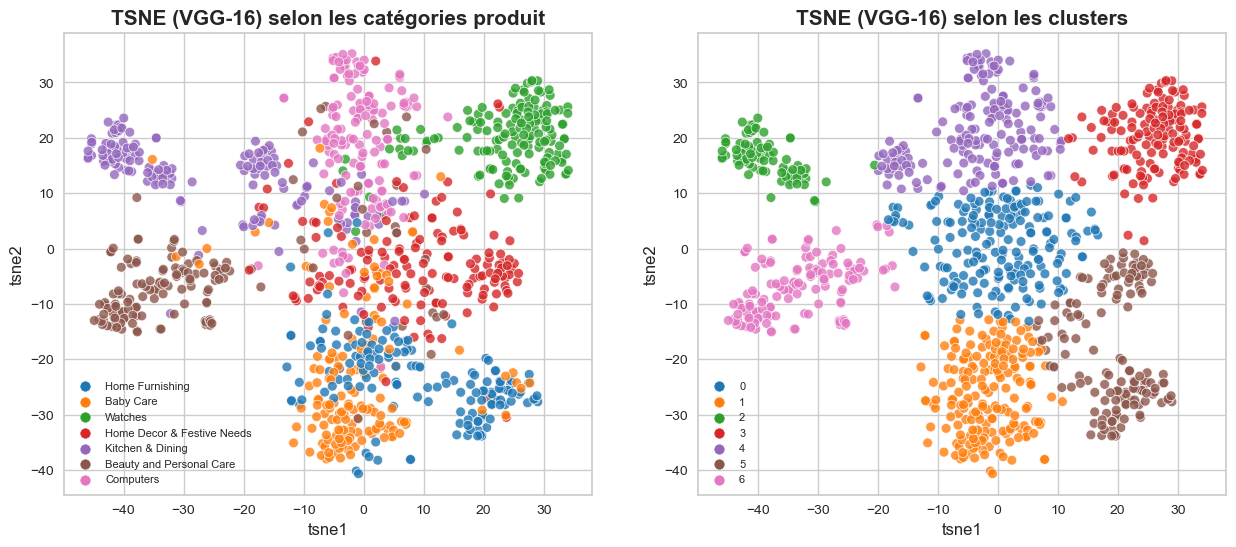

---------------------------
ARI :  0.45845032611870706
---------------------------


In [44]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(121)
    

sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne_vgg16, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.8)

plt.title('TSNE (VGG-16) selon les catégories produit', fontsize = 15, fontweight = 'bold')
plt.xlabel('tsne1')
plt.ylabel('tsne2')
plt.legend(prop={'size': 8}) 



ax = fig.add_subplot(122)
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.8,
    data=df_tsne_vgg16,
    legend="brief")

plt.title('TSNE (VGG-16) selon les clusters', fontsize = 15 , fontweight = 'bold')
plt.xlabel('tsne1')
plt.ylabel('tsne2')
plt.legend(prop={'size': 8}) 

plt.show()


print("---------------------------")
labels = data_image["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))
print("---------------------------")


### la matrice de confusion

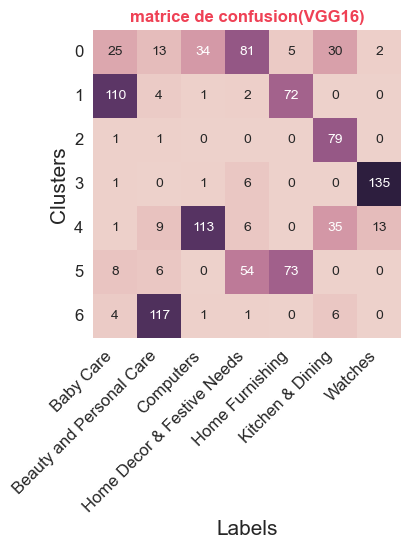

In [45]:
confusion_matrix(df_tsne_vgg16["class"], df_tsne_vgg16["cluster"], 'matrice de confusion(VGG16)')

## <font color = "#ef4155"> **Conclusion faisabilité avec données visuelles**

Le VGG-16 a donné de meilleurs résultats que le SIFT. Cependant :
* son score ARI reste faible : éagl à 0,46 ;
* La matrice de confusion et la visualisation des clusters montrent que les catégories de produits ont de nombreux points de similitudes.

Ce résultats est identique à celui obtenu dans le notebook précédant (traitement des données textes).

En conséquent, ni les données textes et les données visuelles ne permettent de conclure sur la faisabilité de la catégorisation automatique des articles. Je vais vérifier si la combinaison des données textes et visuelles permettrait d'obtenir de meilleurs résultats.

## <font color = "#ef4155"> **Combinaison images et textes**

L'objectif de cette dernière partie est de combiner l'approche NLP des descriptions produits et la partie Computer Vision des images produits.

Voici ma démarche :
* Concatener les datasets obtenus avec le TF-IDF et VGG16;
* Mesurer la performances en calculant le score ARI.

#### <font color = "blue"> **Concaténation avec le dataset TF-IDF** 

_**Chargement des données réduit du modèle TF-IDF**_

In [46]:
pca_results_tfidf = np.genfromtxt("pca_results_tfidf.csv", delimiter=',')

_**Fusion du modèle TF-IDF et VGG16**_

In [47]:
concatenated_features = np.hstack((pca_results_tfidf, pca_results_vgg16))

In [48]:
cls_concatenated = KMeans(n_clusters=7, init='k-means++', random_state=0, n_init = 10)
cls_concatenated.fit(concatenated_features)

KMeans(n_clusters=7, n_init=10, random_state=0)

In [49]:
tsne_concatenated = manifold.TSNE(n_components=2, perplexity=30, 
                                  n_iter=2000, init='random', random_state=6)
tsne_results_concatenated = tsne_concatenated.fit_transform(concatenated_features)

df_tsne_concatenated = pd.DataFrame(tsne_results_concatenated[:, 0:2], columns=['tsne1', 'tsne2'])
df_tsne_concatenated["class"] = data["categorie"]

# Ajouter les clusters obtenus à partir de la concaténation
df_tsne_concatenated["cluster"] = cls_concatenated.labels_

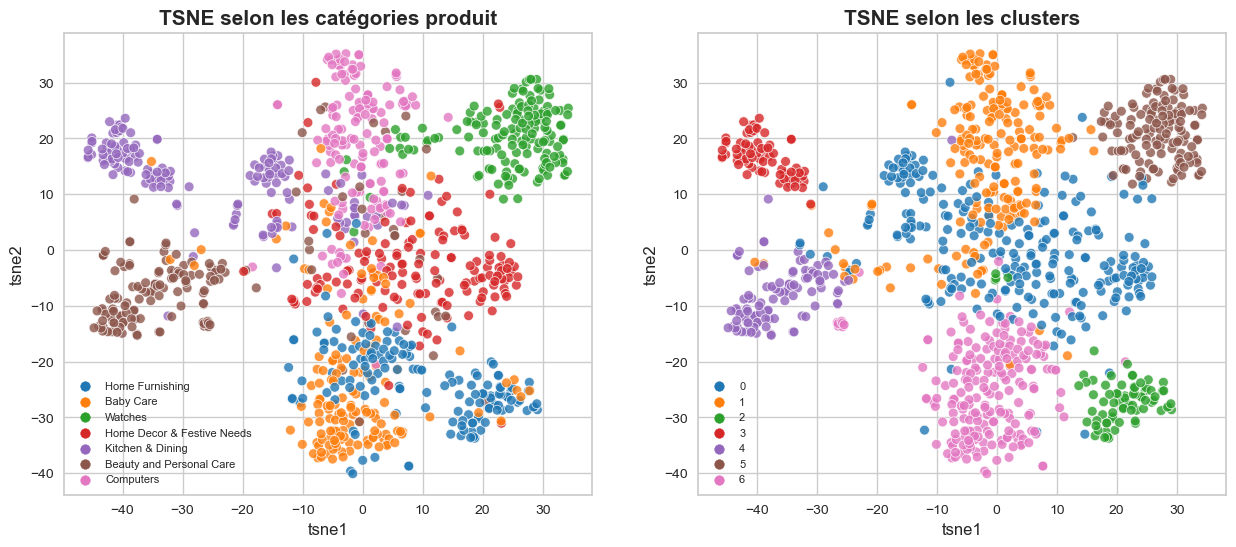

---------------------------
ARI après concaténation :  0.48
---------------------------


In [50]:

# Visualisation des résultats de la concaténation
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(121)
    

sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne_concatenated, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.8)

plt.title('TSNE selon les catégories produit', fontsize = 15, fontweight = 'bold')
plt.xlabel('tsne1')
plt.ylabel('tsne2')
plt.legend(prop={'size': 8}) 



ax = fig.add_subplot(122)
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.8,
    data=df_tsne_concatenated,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 15 , fontweight = 'bold')
plt.xlabel('tsne1')
plt.ylabel('tsne2')
plt.legend(prop={'size': 8}) 

plt.show()


# Calcul du score ARI pour les clusters obtenus à partir de la concaténation
ARI_concatenated = round(metrics.adjusted_rand_score(labels, cls_concatenated.labels_), 3)
print("---------------------------")
print("ARI après concaténation : ", ARI_concatenated)
print("---------------------------")


La Fusion des données textes et visuelles n'améliorent pas les résultats.

_**Sauvegarde du modèle VGG16 pour la classification supervisée à partir des images**_

In [52]:
# Sauvegarde du jeu de données
data_image.to_csv('data_image.csv', index=False)

In [53]:
data_image

image  \
0     55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1     7b72c92c2f6c40268628ec5f14c6d590.jpg   
2     64d5d4a258243731dc7bbb1eef49ad74.jpg   
3     d4684dcdc759dd9cdf41504698d737d8.jpg   
4     6325b6870c54cd47be6ebfbffa620ec7.jpg   
...                                    ...   
1045  958f54f4c46b53c8a0a9b8167d9140bc.jpg   
1046  fd6cbcc22efb6b761bd564c28928483c.jpg   
1047  5912e037d12774bb73a2048f35a00009.jpg   
1048  c3edc504d1b4f0ba6224fa53a43a7ad6.jpg   
1049  f2f027ad6a6df617c9f125173da71e44.jpg   

                                          image_loc        categorie  \
0     ./Images/55b85ea15a1536d46b7190ad6fff8ce7.jpg  Home Furnishing   
1     ./Images/7b72c92c2f6c40268628ec5f14c6d590.jpg        Baby Care   
2     ./Images/64d5d4a258243731dc7bbb1eef49ad74.jpg        Baby Care   
3     ./Images/d4684dcdc759dd9cdf41504698d737d8.jpg  Home Furnishing   
4     ./Images/6325b6870c54cd47be6ebfbffa620ec7.jpg  Home Furnishing   
...                                             ...              ...   
1045  ./Images/958f54f4c46b53c8a0a9b8167d9140bc.jpg        Baby Care   
1046  ./Images/fd6cbcc22efb6b761bd564c28928483c.jpg        Baby Care   
1047  ./Images/5912e037d12774bb73a2048f35a00009.jpg        Baby Care   
1048  ./Images/c3edc504d1b4f0ba6224fa53a43a7ad6.jpg        Baby Care   
1049  ./Images/f2f027ad6a6df617c9f125173da71e44.jpg        Baby Care   

      Largeur_image  Hauteur_image  Taille_image Format_image  \
0              3600           3600      12960000          RGB   
1              2388           1293       3087684          RGB   
2               982            729        715878          RGB   
3              1100            831        914100          RGB   
4              2670           2088       5574960          RGB   
...             ...            ...           ...          ...   
1045           1100            937       1030700          RGB   
1046            900           1200       1080000          RGB   
1047           1100           1011       1112100          RGB   
1048            900           1200       1080000          RGB   
1049           1100           1100       1210000          RGB   

                                       images_processed  label  \
0     ./Images/Image_process/55b85ea15a1536d46b7190a...      4   
1     ./Images/Image_process/7b72c92c2f6c40268628ec5...      0   
2     ./Images/Image_process/64d5d4a258243731dc7bbb1...      0   
3     ./Images/Image_process/d4684dcdc759dd9cdf41504...      4   
4     ./Images/Image_process/6325b6870c54cd47be6ebfb...      4   
...                                                 ...    ...   
1045  ./Images/Image_process/958f54f4c46b53c8a0a9b81...      0   
1046  ./Images/Image_process/fd6cbcc22efb6b761bd564c...      0   
1047  ./Images/Image_process/5912e037d12774bb73a2048...      0   
1048  ./Images/Image_process/c3edc504d1b4f0ba6224fa5...      0   
1049  ./Images/Image_process/f2f027ad6a6df617c9f1251...      0   

                                             vgg16_bovw  
0     [3.3986163, 0.8595723, 0.0, 1.1065612, 2.26612...  
1     [0.0, 0.0, 0.0, 1.1720098, 0.0, 0.0, 0.0, 0.0,...  
2     [0.0, 0.0, 0.0, 4.457807, 0.0, 0.0, 0.0, 0.0, ...  
3     [0.0, 0.07099047, 0.0, 2.0462809, 0.0, 0.0, 0....  
4     [3.417153, 0.0, 0.0, 0.0, 1.0123595, 0.0, 0.0,...  
...                                                 ...  
1045  [2.312268, 2.4329371, 0.0, 1.8605151, 3.101231...  
1046  [1.2171843, 0.365275, 0.33084896, 0.0, 2.14062...  
1047  [2.1961296, 2.398275, 2.623641, 0.98388314, 0....  
1048  [0.0, 0.0, 0.0, 0.0, 0.0, 0.38886583, 0.0, 0.0...  
1049  [0.0, 0.0, 0.123131216, 0.0, 0.34228462, 0.0, ...  

[1050 rows x 10 columns]